In [1]:
#from create_maps import *
import numpy as np
import nibabel.freesurfer.io as fsio
from functools import reduce
import nibabel as nib
import numpy as np
from nilearn import plotting
import os

lh_f = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer/label/lh.aparc.a2009s.annot"
rh_f = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer/label/rh.aparc.a2009s.annot"

def load_annot_to_full_binary_dict(lh_annot_file, rh_annot_file):
    """
    Load left and right hemisphere .annot files and create a dictionary of binary maps
    for regions in the full fsaverage6 surface space (81,924 vertices total).

    Each binary map is of shape (81924,), with the left hemisphere occupying the first 40962 indices,
    and the right hemisphere occupying the last 40962 indices. Non-relevant hemisphere regions are zero-padded.

    Parameters:
    - lh_annot_file: Path to the left hemisphere .annot file.
    - rh_annot_file: Path to the right hemisphere .annot file.

    Returns:
    - region_dict: Dictionary where keys are region names (prefixed with L_ or R_) and values are binary arrays.
    """
    region_dict = {}
    num_vertices = 40962  # fsaverage6 has 40,962 vertices per hemisphere

    # Left hemisphere
    lh_labels, _, lh_names = fsio.read_annot(lh_annot_file)
    for i, name in enumerate(lh_names):
        region_name = f"L_{name.decode('utf-8')}"
        binary_lh = (lh_labels == i).astype(int)
        binary_full = np.concatenate([binary_lh, np.zeros(num_vertices, dtype=int)])
        region_dict[region_name] = binary_full

    # Right hemisphere
    rh_labels, _, rh_names = fsio.read_annot(rh_annot_file)
    for i, name in enumerate(rh_names):
        region_name = f"R_{name.decode('utf-8')}"
        binary_rh = (rh_labels == i).astype(int)
        binary_full = np.concatenate([np.zeros(num_vertices, dtype=int), binary_rh])
        region_dict[region_name] = binary_full

    return region_dict

region_dict = load_annot_to_full_binary_dict(lh_f, rh_f)
brocas = ["L_G_front_inf-Opercular", "L_G_front_inf-Triangul"]
#use a boolean OR to combine all regions in brocas
broca_map = reduce(np.bitwise_or, [region_dict[region] for region in brocas])

print(np.mean(broca_map))
print(np.sum(broca_map))

fsaverage_dir = "/home/wsm32/project/wsm_thesis_scratch/narratives/fs6_transfer"
lh_pial = os.path.join(fsaverage_dir, "surf", "lh.pial")
rh_pial = os.path.join(fsaverage_dir, "surf", "rh.pial")


large_baseline = "/home/wsm32/project/wsm_thesis_scratch/narratives/rt_large/0.001-0.5-2-128-0.05-8-16/best_model.pt"
small_baseline = "/home/wsm32/project/wsm_thesis_scratch/narratives/rt_large/0.001-0.5-1-64-0.05-4-16/best_model.pt"


def load_embeds(this_file):
    m = torch.load(this_file, map_location=torch.device('cpu'))['model']
    return m["module.encoder.en_emd.weight"].numpy()

def region_similarity(this_file, strategy, region):
    weights_sq = load_embeds(this_file) ** 2
    results = ((weights_sq) @ region) / np.linalg.norm(region)
    results = results / np.linalg.norm(weights_sq, axis = 1)
    return strategy(results)

def compute_broca_sim(this_file, strategy):
    weights_sq = load_embeds(this_file) ** 2
    results = ((weights_sq) @ broca_map) / np.linalg.norm(broca_map)
    results = results / np.linalg.norm(weights_sq, axis = 1)
    return strategy(results)

    

0.008874078414139935
727


In [2]:
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
from pathlib import Path

def load_scalars_to_df(summary_dir, reload=True):
    """
    Load scalar logs from a TensorBoard summary directory into a DataFrame.

    Parameters:
    - summary_dir (str or Path): Path to directory containing event files.
    - reload (bool): Whether to call Reload() on the event accumulator.

    Returns:
    - df (pd.DataFrame): DataFrame with one column per scalar tag and rows indexed by step.
    """
    summary_dir = Path(summary_dir)
    
    # Locate the event file (assumes only one or takes the first)
    event_files = list(summary_dir.glob("**/events.out.tfevents.*"))
    if not event_files:
        raise FileNotFoundError(f"No event files found in {summary_dir}")
    
    ea = event_accumulator.EventAccumulator(str(event_files[0]))
    if reload:
        ea.Reload()
    
    scalars_by_tag = {}
    for tag in ea.Tags().get('scalars', []):
        events = ea.Scalars(tag)
        scalars_by_tag[tag] = pd.Series(
            data=[e.value for e in events],
            index=[e.step for e in events],
            name=tag
        )
    
    # Merge all Series into a single DataFrame on the step index
    df = pd.concat(scalars_by_tag.values(), axis=1)
    df.index.name = "step"
    
    return df.reset_index()


Baseline 0.03761053495581447


Text(0, 0.5, 'validation perplexity')

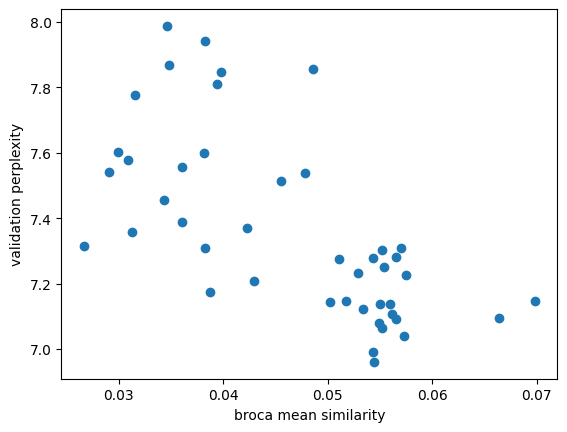

In [3]:
from pathlib import Path
import torch
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter("ignore", FutureWarning)
root_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/predictors")

print("Baseline", compute_broca_sim(large_baseline, np.mean))


model_broca_sims = []
model_max_bs = []
model_min_perp = []


for subdir in root_dir.iterdir():
        if subdir.is_dir() and ("thaw_cross-none" in str(subdir) or "none-none" in str(subdir)) and "0.001" in str(subdir):
            comp_model = subdir / "best_predictor_model.pt"
            #print("Directory:", subdir)

            model_broca_sims.append(compute_broca_sim(comp_model, np.mean))
            model_max_bs.append(compute_broca_sim(comp_model, np.max))
            
            train_info = load_scalars_to_df(subdir/ "summary")
            model_min_perp.append(train_info["Val_Perp"].min())
        #break

plt.scatter(model_broca_sims, model_min_perp)
plt.xlabel("broca mean similarity")
plt.ylabel("validation perplexity")

Text(0, 0.5, 'validation perplexity')

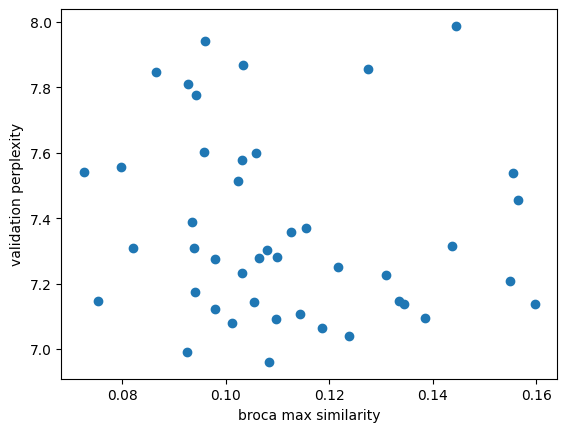

In [34]:
plt.scatter(model_max_bs, model_min_perp)
plt.xlabel("broca max similarity")
plt.ylabel("validation perplexity")

In [35]:
from scipy.stats import pearsonr, spearmanr


print(pearsonr(model_broca_sims, model_min_perp))

print(pearsonr(model_max_bs, model_min_perp))

PearsonRResult(statistic=np.float64(-0.6580907366546382), pvalue=np.float64(1.2056869138955724e-06))
PearsonRResult(statistic=np.float64(-0.13225482776944192), pvalue=np.float64(0.392112790204918))


In [10]:
from scipy import stats
region_names = region_dict.keys()
ps = {}

for rn in region_names:
    if np.sum(region_dict[rn]) > 0:
        baseline = region_similarity(large_baseline, np.mean, region_dict[rn])
        data = []
        for subdir in root_dir.iterdir():
            if subdir.is_dir() and "large" in str(subdir) and "thaw_cross-none" in str(subdir) and "0.001" in str(subdir):
                comp_model = subdir / "best_predictor_model.pt"
                data += [region_similarity(comp_model, np.mean, region_dict[rn])]
        t, p = stats.ttest_1samp(data, popmean=baseline)
        ps[rn] = p


/tmp/tmp.xMiG0mWN1n/ipykernel_2773437/3945265089.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m = torch.load(this_file, map_location=torch.device('cpu'))['model']


{'L_G_and_S_frontomargin': np.float64(0.00014642416983426772), 'L_G_and_S_occipital_inf': np.float64(0.002193473787224521), 'L_G_and_S_paracentral': np.float64(1.683671020997556e-05), 'L_G_and_S_subcentral': np.float64(0.0012103675355110122), 'L_G_and_S_transv_frontopol': np.float64(0.004729204038654319), 'L_G_and_S_cingul-Ant': np.float64(3.0593199592495445e-06), 'L_G_and_S_cingul-Mid-Ant': np.float64(1.899619426404678e-08), 'L_G_and_S_cingul-Mid-Post': np.float64(0.00011455664683898677), 'L_G_cingul-Post-dorsal': np.float64(0.0005560413791547606), 'L_G_cingul-Post-ventral': np.float64(0.043659403620950984), 'L_G_cuneus': np.float64(0.00028062974866026325), 'L_G_front_inf-Opercular': np.float64(9.623839669338882e-06), 'L_G_front_inf-Orbital': np.float64(0.015974980855441148), 'L_G_front_inf-Triangul': np.float64(0.0008013603518154363), 'L_G_front_middle': np.float64(7.165021308970085e-07), 'L_G_front_sup': np.float64(4.393706156483701e-08), 'L_G_Ins_lg_and_S_cent_ins': np.float64(0.00

In [10]:
from pathlib import Path
import torch
import warnings
import re
import json
import matplotlib.pyplot as plt
def extract_json_from_output(output: str) -> str:
    pattern = r"PERM_BEGIN\s*(.*?)\s*PERM_END"
    match = re.search(pattern, output, re.DOTALL)
    if not match:
        raise ValueError("Markers PERM_BEGIN and PERM_END not found.")
    return match.group(1)


warnings.simplefilter("ignore", FutureWarning)
root_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/predictors")
perm_test_dir = Path("/home/wsm32/project/wsm_thesis_scratch/narratives/combined_run/perm_testing")

default_perp = []
perm_perp = []


ptest_succ = 0

for subdir in root_dir.iterdir():
        if subdir.is_dir():# and ("thaw_cross-none" in str(subdir) or "none-none" in str(subdir)): and "0.001" in str(subdir):
            comp_model = subdir / "best_predictor_model.pt"
            #print("Directory:", subdir)

            train_info = load_scalars_to_df(subdir/ "summary")
            model_step = train_info["Val_Loss"].idxmin()
            default_perp += [train_info.loc[model_step, "Val_Perp"]]

            try:
                with open(str(perm_test_dir) +"/"+ (str(subdir.name) + ".txt"), "r") as f:
                    obj = json.loads(extract_json_from_output(f.read()))
                    perm_perp += [obj["perp"]]
            except Exception as e:
                print(f"Error processing: {e}")

        #break
print(len(perm_perp))
print(len(default_perp))

perm_diff = [perm_perp[a] - default_perp[a] for a in range(len(perm_perp))]
print(np.mean(perm_diff))
print(len(perm_diff))

177
177
0.03484216887798347
177


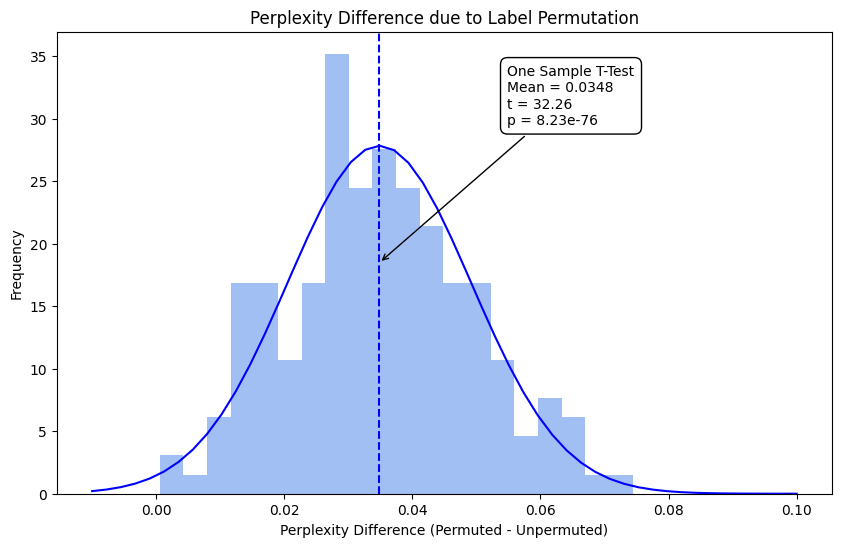

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_1samp

# Example data
# perm_diff = np.random.normal(loc=0.02, scale=0.01, size=100)  # Replace with your data

# One-sample t-test
t_stat, p_value = ttest_1samp(perm_diff, popmean=0)
mean_val = np.mean(perm_diff)

# Plot
plt.figure(figsize=(10, 6))
x = np.linspace(-0.01, 0.1)
plt.hist(perm_diff, bins=20, density=True, alpha=0.6, color='cornflowerblue')
plt.plot(x, norm.pdf(x, mean_val, np.std(perm_diff)), color="blue")
mean_line = plt.axvline(mean_val, color="blue", linestyle="--")

# Annotation text
textstr = (
    "One Sample T-Test\n"
    f"Mean = {mean_val:.4f}\n"
    f"t = {t_stat:.2f}\n"
    f"p = {p_value:.3g}"
)

# Annotate with arrow pointing to mean line
plt.annotate(
    textstr,
    xy=(mean_val, plt.ylim()[1]*0.5),      # Arrow target
    xytext=(mean_val + 0.02, plt.ylim()[1]*0.8),  # Box position
    arrowprops=dict(facecolor='black', arrowstyle="->"),
    bbox=dict(boxstyle="round,pad=0.5", edgecolor='black', facecolor='white'),
    ha='left'
)

plt.title("Perplexity Difference due to Label Permutation")
plt.xlabel("Perplexity Difference (Permuted - Unpermuted)")
plt.ylabel("Frequency")
plt.show()


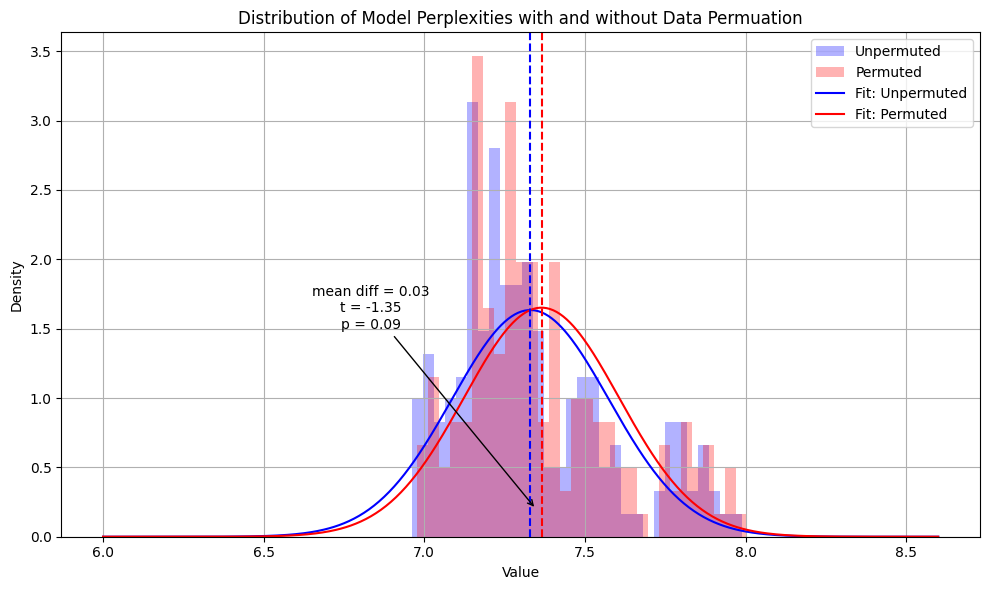

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind

# Generate sample data
np.random.seed(0)
group1 = default_perp
group2 = perm_perp

# Fit Gaussians
mean1, std1 = np.mean(group1), np.std(group1)
mean2, std2 = np.mean(group2), np.std(group2)

# Perform t-test
t_stat, p_val = ttest_ind(group1, group2, alternative="less")

# X values for plotting Gaussians
x = np.linspace(6, 8.6, 500)

# Plot the distributions
plt.figure(figsize=(10, 6))

# Histogram or KDE-like curves
plt.hist(group1, bins=30, density=True, alpha=0.3, label="Unpermuted", color="blue")
plt.hist(group2, bins=30, density=True, alpha=0.3, label="Permuted", color="red")

# Plot fitted Gaussian curves
plt.plot(x, norm.pdf(x, mean1, std1), label="Fit: Unpermuted", color="blue")
plt.plot(x, norm.pdf(x, mean2, std2), label="Fit: Permuted", color="red")

# Plot means
plt.axvline(mean1, color="blue", linestyle="--")
plt.axvline(mean2, color="red", linestyle="--")


plt.annotate(
    f"mean diff = {mean2 - mean1:.2f}\nt = {t_stat:.2f}\np = {p_val:.2f}",
    xy=((mean1 + mean2) / 2, 0.2),
    xytext=((mean1 + mean2) / 2.15, 1.5),
    textcoords="data",
    ha="center",
    arrowprops=dict(arrowstyle="->", color="black")
)

plt.title("Distribution of Model Perplexities with and without Data Permuation")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
